### set-up

In [11]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from IPython import display as disp
from torch.nn.utils import spectral_norm   
from torch import optim 
import os

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device.type)

# helper function to make getting another batch of data easier
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

class_names = ['apple','aquarium_fish','baby','bear','beaver','bed','bee','beetle','bicycle','bottle','bowl','boy','bridge','bus','butterfly','camel','can','castle','caterpillar','cattle','chair','chimpanzee','clock','cloud','cockroach','couch','crab','crocodile','cup','dinosaur','dolphin','elephant','flatfish','forest','fox','girl','hamster','house','kangaroo','computer_keyboard','lamp','lawn_mower','leopard','lion','lizard','lobster','man','maple_tree','motorcycle','mountain','mouse','mushroom','oak_tree','orange','orchid','otter','palm_tree','pear','pickup_truck','pine_tree','plain','plate','poppy','porcupine','possum','rabbit','raccoon','ray','road','rocket','rose','sea','seal','shark','shrew','skunk','skyscraper','snail','snake','spider','squirrel','streetcar','sunflower','sweet_pepper','table','tank','telephone','television','tiger','tractor','train','trout','tulip','turtle','wardrobe','whale','willow_tree','wolf','woman','worm',]

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR100('data', train=True, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])),
    batch_size=64, drop_last=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR100('data', train=False, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize([32,32]),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])),
    batch_size=64, drop_last=True)

train_iterator = iter(cycle(train_loader))
test_iterator = iter(cycle(test_loader))

print(f'> Size of training dataset {len(train_loader.dataset)}')
print(f'> Size of test dataset {len(test_loader.dataset)}')
print("Number of classes: ", len(class_names))

batch_size = 64

num_batches_per_epoch = len(train_loader.dataset) // batch_size

num_of_epochs = 50000 // num_batches_per_epoch

print("Number of batches per epoch: ", num_batches_per_epoch)
print("Number of epochs: ", num_of_epochs)

cuda
Files already downloaded and verified
Files already downloaded and verified
> Size of training dataset 50000
> Size of test dataset 10000
Number of classes:  100
Number of batches per epoch:  781
Number of epochs:  64


### Model

In [12]:
class ResNet(nn.Module):
    def __init__(self, num_classes=100):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        # Create ResNet layers
        self.layer1 = self.make_layer(64, 2, stride=1)
        self.layer2 = self.make_layer(128, 2, stride=2)
        self.layer3 = self.make_layer(256, 2, stride=2)
        self.layer4 = self.make_layer(512, 2, stride=2)
        
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
    def make_layer(self, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(ResidualBlock(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    
    # Define the basic ResNet block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, 
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out
    
def show_images(images, labels, predictions=None, class_names=None):
    num_images = min(25, len(images))  # Show up to 25 images in a 5x5 grid
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        img = images[i].cpu().numpy().transpose((1, 2, 0))
        # Denormalize the images
        mean = np.array([0.5071, 0.4867, 0.4408])
        std = np.array([0.2675, 0.2565, 0.2761])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        plt.imshow(img)
        if predictions is not None and class_names is not None:
            title = f'True: {class_names[labels[i]]}\nPred: {class_names[predictions[i]]}'
        elif class_names is not None:
            title = f'True: {class_names[labels[i]]}'
        else:
            title = f'Class: {labels[i]}'
        plt.title(title, fontsize=8)
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
lr_g = 1e-4
lr_d = 4e-4
beta1 = 0.5
beta2 = 0.999

# Initialize networks and optimizers
R = ResNet().to(device)

print("Number of parameters in ResNet: ", sum([p.numel() for p in R.parameters()]))

Number of parameters in ResNet:  11220132


### Training

Epoch [1/64], Step [100/781], Loss: 4.850, Acc: 1.31%
Epoch [1/64], Step [200/781], Loss: 4.489, Acc: 1.80%
Epoch [1/64], Step [300/781], Loss: 4.336, Acc: 2.41%
Epoch [1/64], Step [400/781], Loss: 4.149, Acc: 3.19%
Epoch [1/64], Step [500/781], Loss: 4.017, Acc: 3.90%
Epoch [1/64], Step [600/781], Loss: 3.932, Acc: 4.69%
Epoch [1/64], Step [700/781], Loss: 3.859, Acc: 5.33%


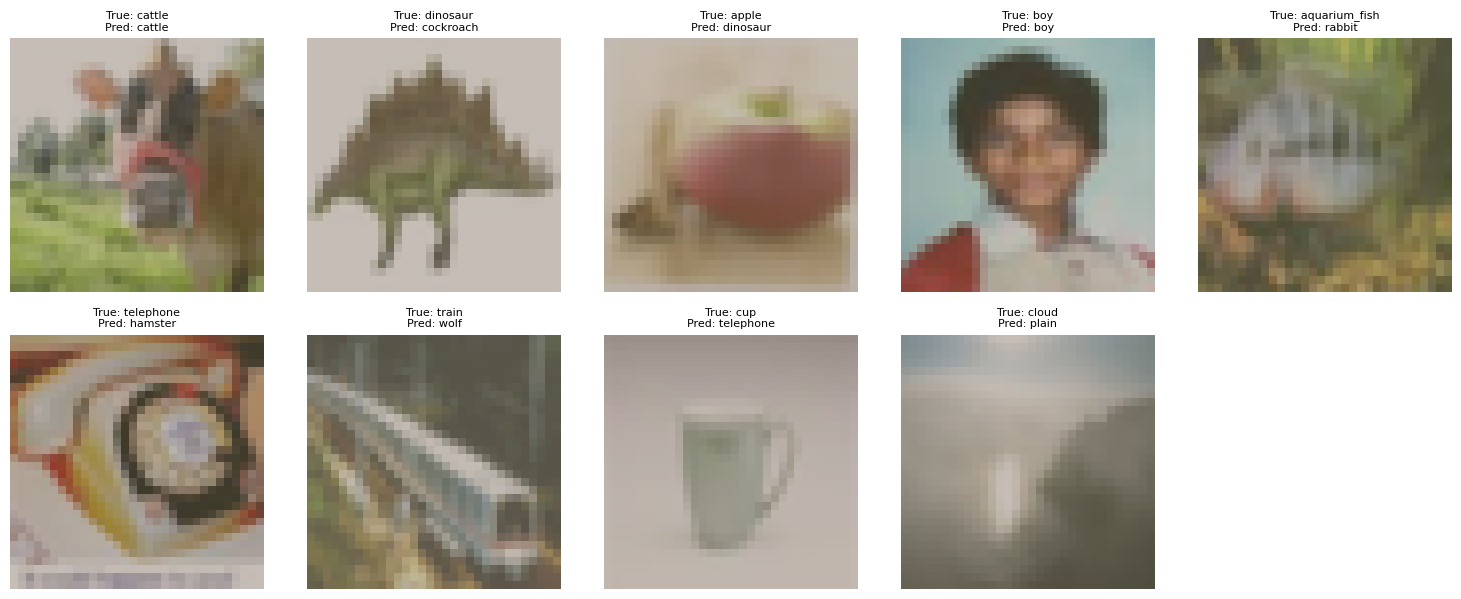

Epoch [2/64], Step [100/781], Loss: 3.741, Acc: 11.47%
Epoch [2/64], Step [200/781], Loss: 3.639, Acc: 12.32%
Epoch [2/64], Step [300/781], Loss: 3.580, Acc: 13.23%
Epoch [2/64], Step [400/781], Loss: 3.518, Acc: 13.89%
Epoch [2/64], Step [500/781], Loss: 3.388, Acc: 14.59%
Epoch [2/64], Step [600/781], Loss: 3.375, Acc: 15.26%
Epoch [2/64], Step [700/781], Loss: 3.338, Acc: 15.72%


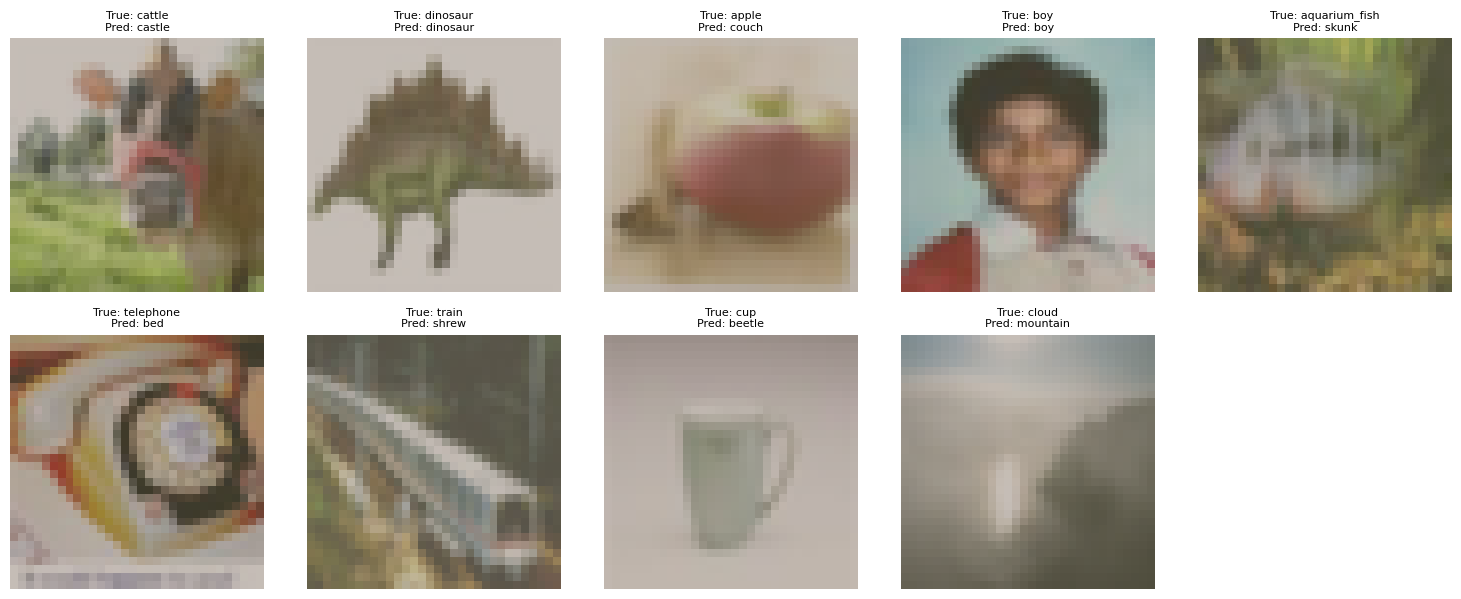

Epoch [3/64], Step [100/781], Loss: 3.283, Acc: 19.67%
Epoch [3/64], Step [200/781], Loss: 3.196, Acc: 20.49%
Epoch [3/64], Step [300/781], Loss: 3.185, Acc: 21.08%
Epoch [3/64], Step [400/781], Loss: 3.175, Acc: 21.18%
Epoch [3/64], Step [500/781], Loss: 3.076, Acc: 21.70%
Epoch [3/64], Step [600/781], Loss: 3.068, Acc: 22.09%
Epoch [3/64], Step [700/781], Loss: 3.049, Acc: 22.39%


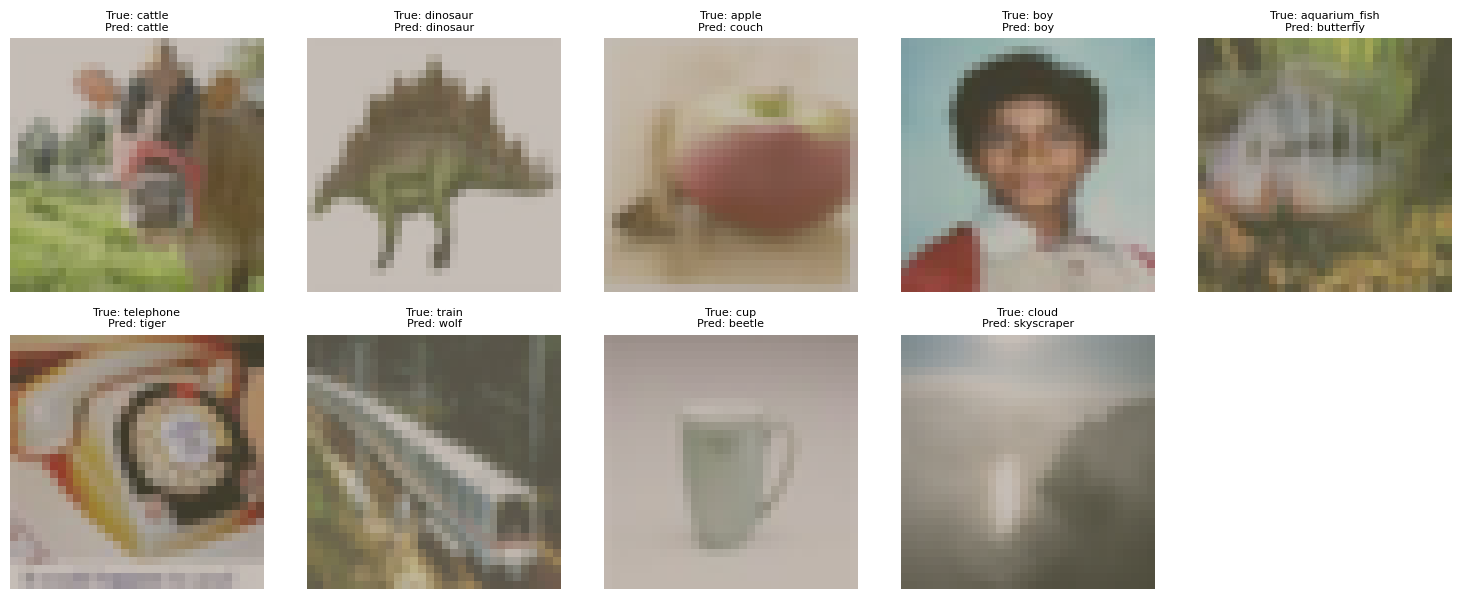

Epoch [4/64], Step [100/781], Loss: 3.008, Acc: 24.61%
Epoch [4/64], Step [200/781], Loss: 2.913, Acc: 25.83%
Epoch [4/64], Step [300/781], Loss: 2.917, Acc: 26.33%
Epoch [4/64], Step [400/781], Loss: 2.906, Acc: 26.23%
Epoch [4/64], Step [500/781], Loss: 2.805, Acc: 26.71%
Epoch [4/64], Step [600/781], Loss: 2.813, Acc: 27.08%
Epoch [4/64], Step [700/781], Loss: 2.792, Acc: 27.34%


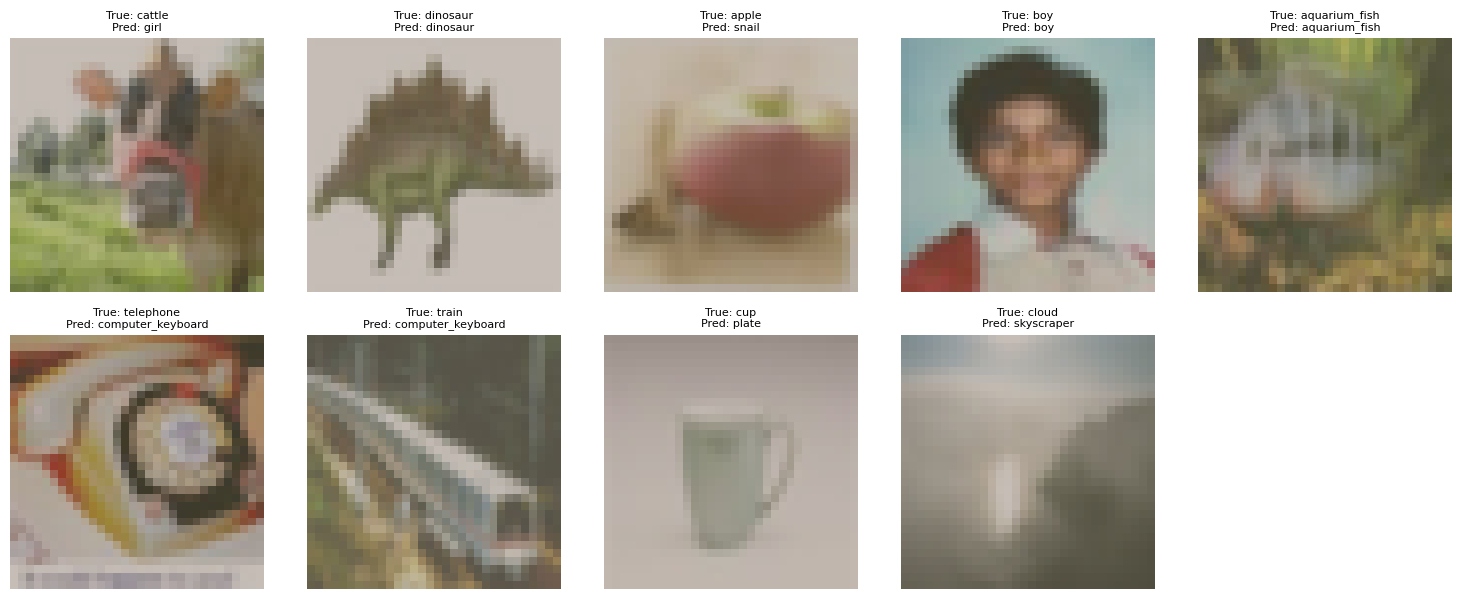

Epoch [5/64], Step [100/781], Loss: 2.755, Acc: 29.89%
Epoch [5/64], Step [200/781], Loss: 2.671, Acc: 31.01%
Epoch [5/64], Step [300/781], Loss: 2.675, Acc: 31.08%
Epoch [5/64], Step [400/781], Loss: 2.680, Acc: 30.94%
Epoch [5/64], Step [500/781], Loss: 2.570, Acc: 31.43%
Epoch [5/64], Step [600/781], Loss: 2.600, Acc: 31.72%
Epoch [5/64], Step [700/781], Loss: 2.576, Acc: 31.88%


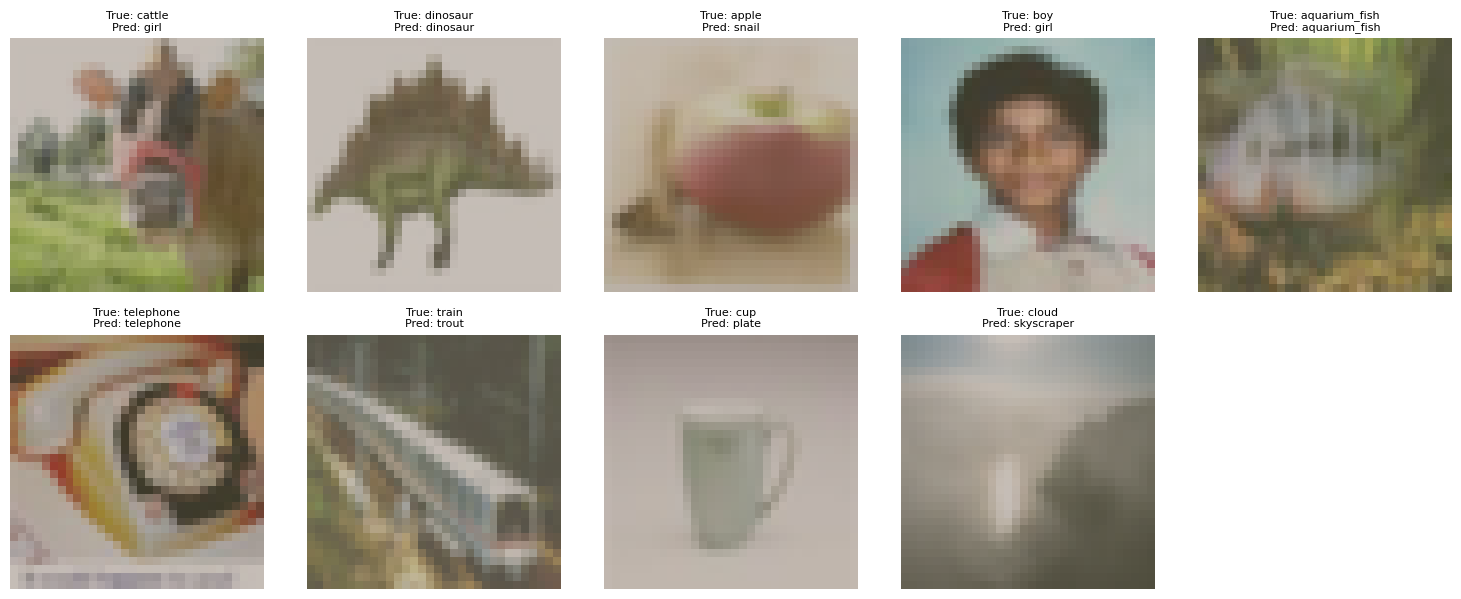

Epoch [6/64], Step [100/781], Loss: 2.540, Acc: 34.02%
Epoch [6/64], Step [200/781], Loss: 2.463, Acc: 35.04%
Epoch [6/64], Step [300/781], Loss: 2.468, Acc: 35.36%
Epoch [6/64], Step [400/781], Loss: 2.452, Acc: 35.40%
Epoch [6/64], Step [500/781], Loss: 2.379, Acc: 35.74%
Epoch [6/64], Step [600/781], Loss: 2.408, Acc: 35.95%
Epoch [6/64], Step [700/781], Loss: 2.387, Acc: 36.19%


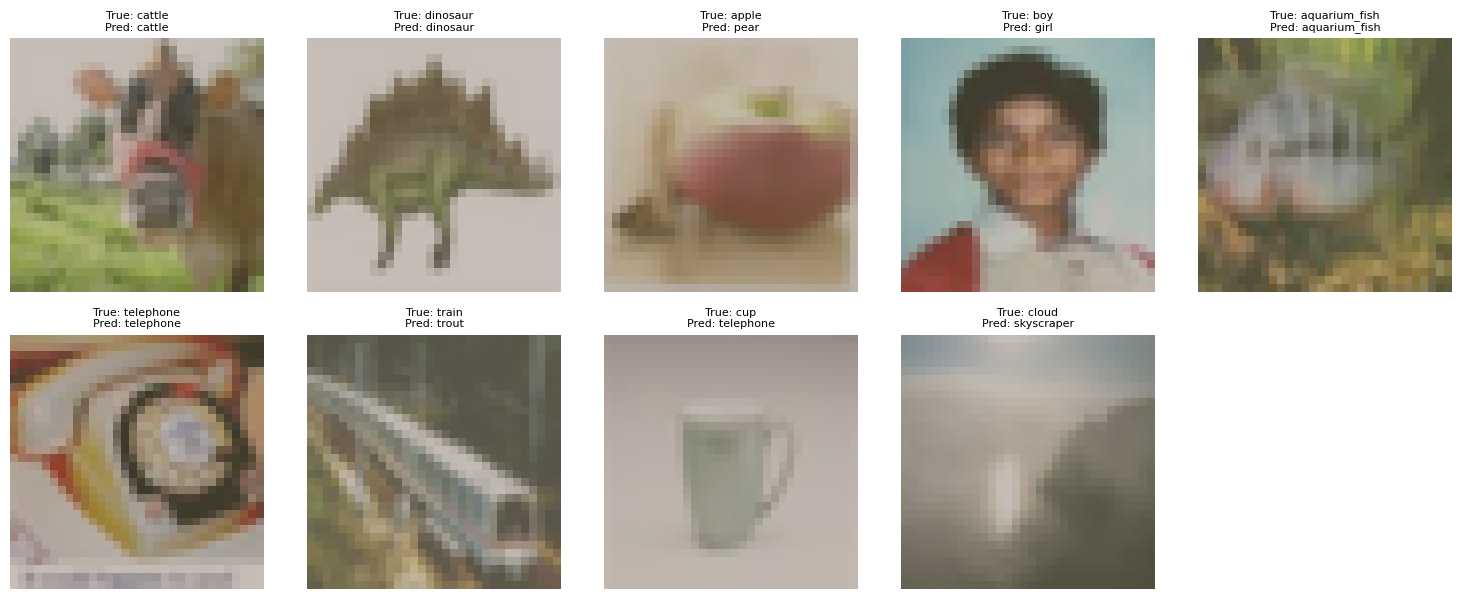

Epoch [7/64], Step [100/781], Loss: 2.357, Acc: 38.62%
Epoch [7/64], Step [200/781], Loss: 2.289, Acc: 38.66%
Epoch [7/64], Step [300/781], Loss: 2.286, Acc: 39.11%
Epoch [7/64], Step [400/781], Loss: 2.277, Acc: 39.27%
Epoch [7/64], Step [500/781], Loss: 2.201, Acc: 39.69%
Epoch [7/64], Step [600/781], Loss: 2.227, Acc: 39.99%
Epoch [7/64], Step [700/781], Loss: 2.219, Acc: 40.23%


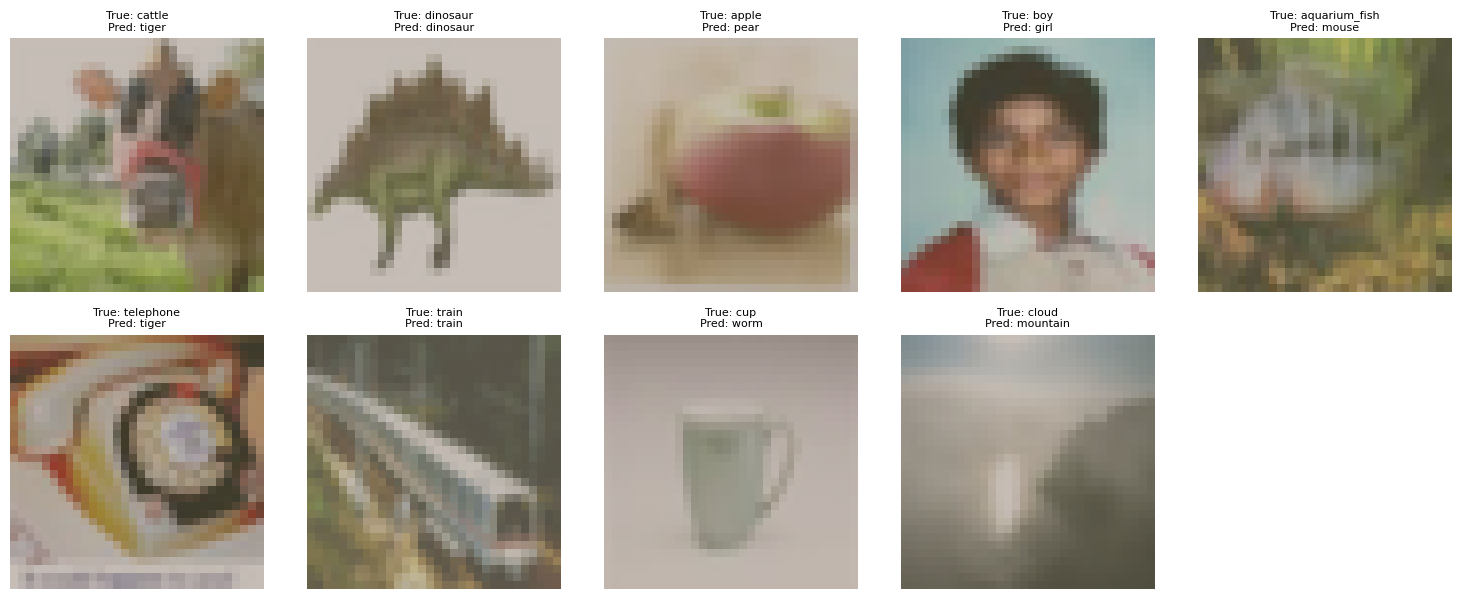

Epoch [8/64], Step [100/781], Loss: 2.206, Acc: 40.98%
Epoch [8/64], Step [200/781], Loss: 2.120, Acc: 41.77%
Epoch [8/64], Step [300/781], Loss: 2.161, Acc: 41.84%
Epoch [8/64], Step [400/781], Loss: 2.125, Acc: 42.06%
Epoch [8/64], Step [500/781], Loss: 2.084, Acc: 42.40%
Epoch [8/64], Step [600/781], Loss: 2.098, Acc: 42.71%
Epoch [8/64], Step [700/781], Loss: 2.079, Acc: 42.88%


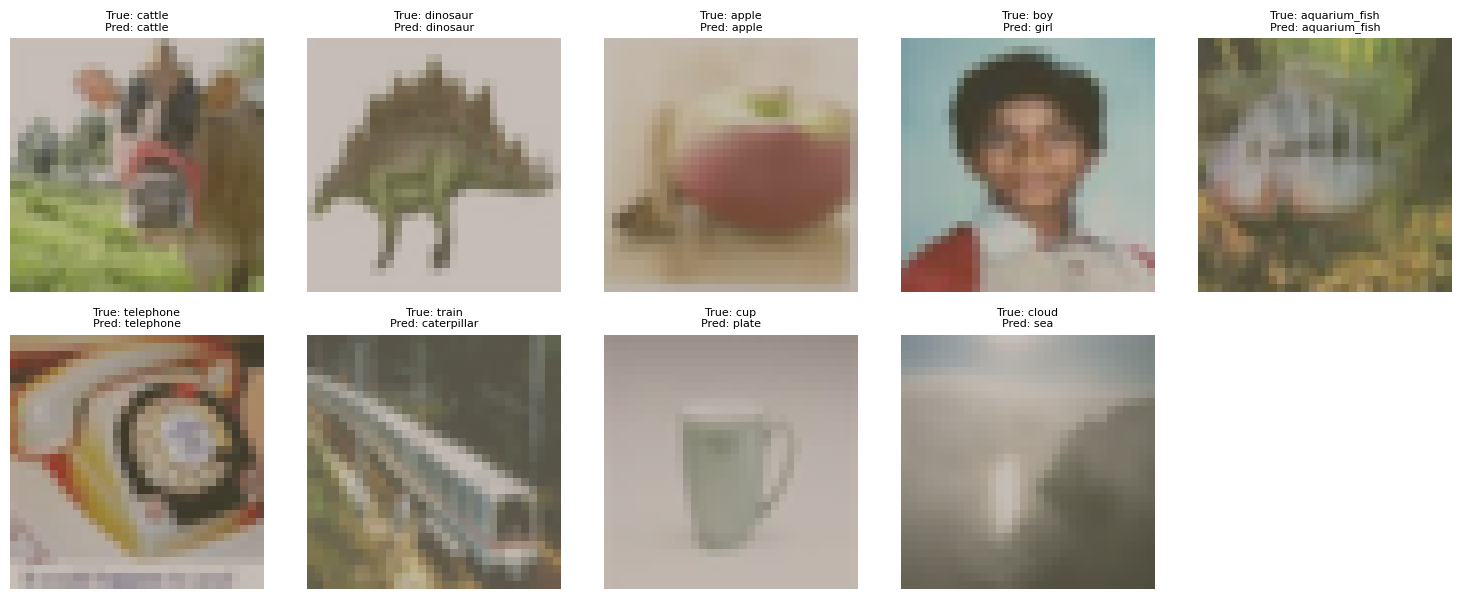

Epoch [9/64], Step [100/781], Loss: 2.106, Acc: 42.97%
Epoch [9/64], Step [200/781], Loss: 2.023, Acc: 43.84%
Epoch [9/64], Step [300/781], Loss: 2.033, Acc: 44.12%
Epoch [9/64], Step [400/781], Loss: 2.031, Acc: 44.34%
Epoch [9/64], Step [500/781], Loss: 1.989, Acc: 44.67%
Epoch [9/64], Step [600/781], Loss: 2.015, Acc: 44.78%
Epoch [9/64], Step [700/781], Loss: 2.001, Acc: 44.92%


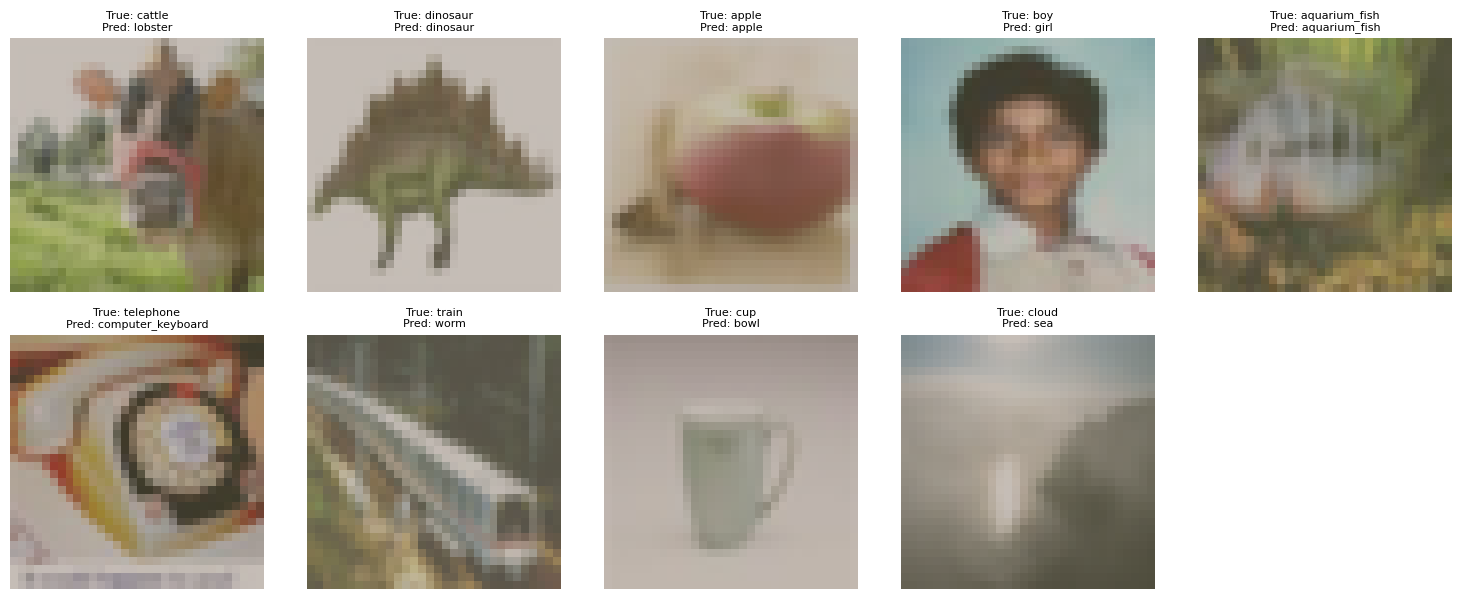

Epoch [10/64], Step [100/781], Loss: 2.012, Acc: 45.66%
Epoch [10/64], Step [200/781], Loss: 1.935, Acc: 46.30%
Epoch [10/64], Step [300/781], Loss: 1.954, Acc: 46.36%
Epoch [10/64], Step [400/781], Loss: 1.967, Acc: 46.39%
Epoch [10/64], Step [500/781], Loss: 1.926, Acc: 46.71%
Epoch [10/64], Step [600/781], Loss: 1.938, Acc: 46.80%
Epoch [10/64], Step [700/781], Loss: 1.914, Acc: 46.97%


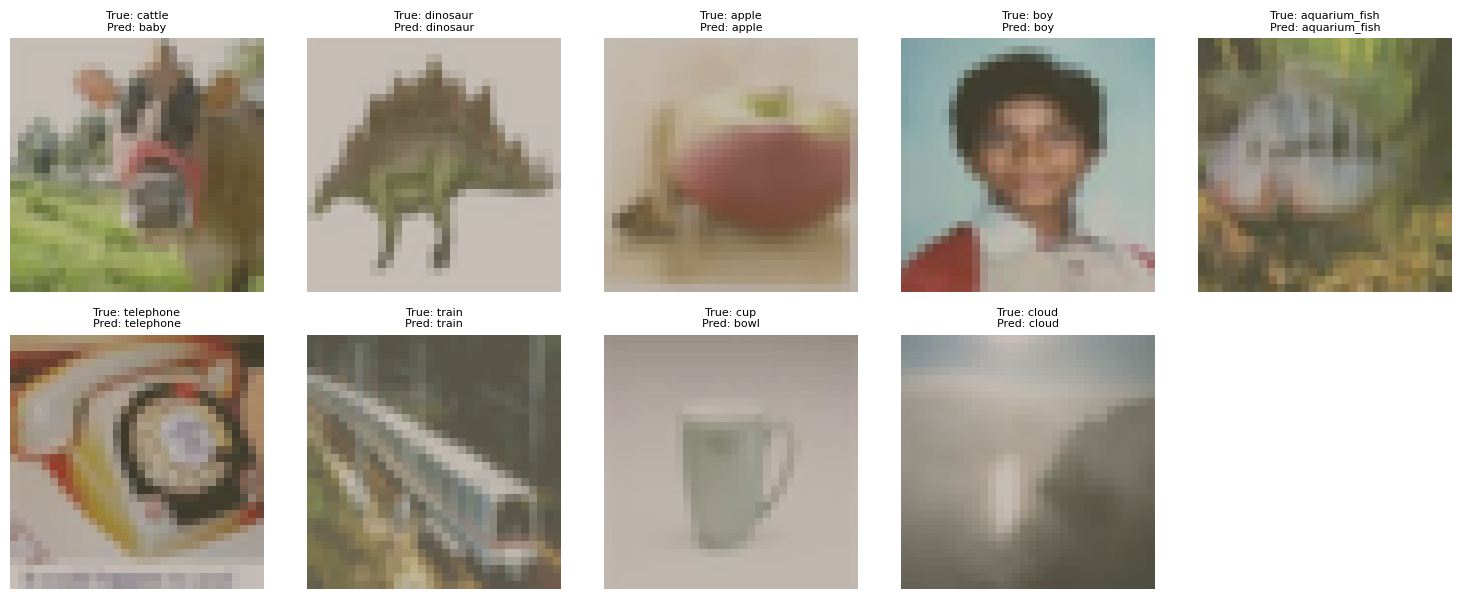

Epoch [11/64], Step [100/781], Loss: 1.940, Acc: 47.05%
Epoch [11/64], Step [200/781], Loss: 1.902, Acc: 47.26%
Epoch [11/64], Step [300/781], Loss: 1.888, Acc: 47.52%
Epoch [11/64], Step [400/781], Loss: 1.902, Acc: 47.66%
Epoch [11/64], Step [500/781], Loss: 1.875, Acc: 47.83%
Epoch [11/64], Step [600/781], Loss: 1.911, Acc: 47.86%
Epoch [11/64], Step [700/781], Loss: 1.878, Acc: 48.02%


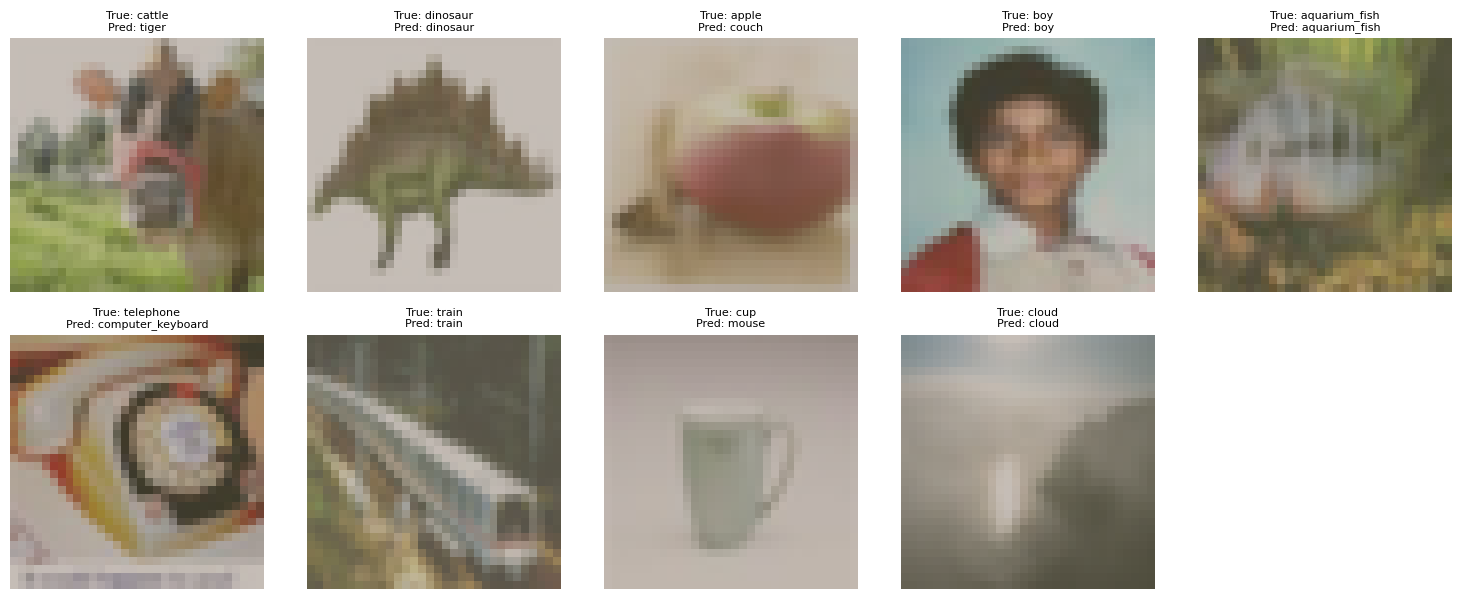

Epoch [12/64], Step [100/781], Loss: 1.905, Acc: 47.88%
Epoch [12/64], Step [200/781], Loss: 1.830, Acc: 48.47%
Epoch [12/64], Step [300/781], Loss: 1.849, Acc: 48.57%
Epoch [12/64], Step [400/781], Loss: 1.866, Acc: 48.75%
Epoch [12/64], Step [500/781], Loss: 1.834, Acc: 48.98%
Epoch [12/64], Step [600/781], Loss: 1.862, Acc: 49.08%
Epoch [12/64], Step [700/781], Loss: 1.840, Acc: 49.16%


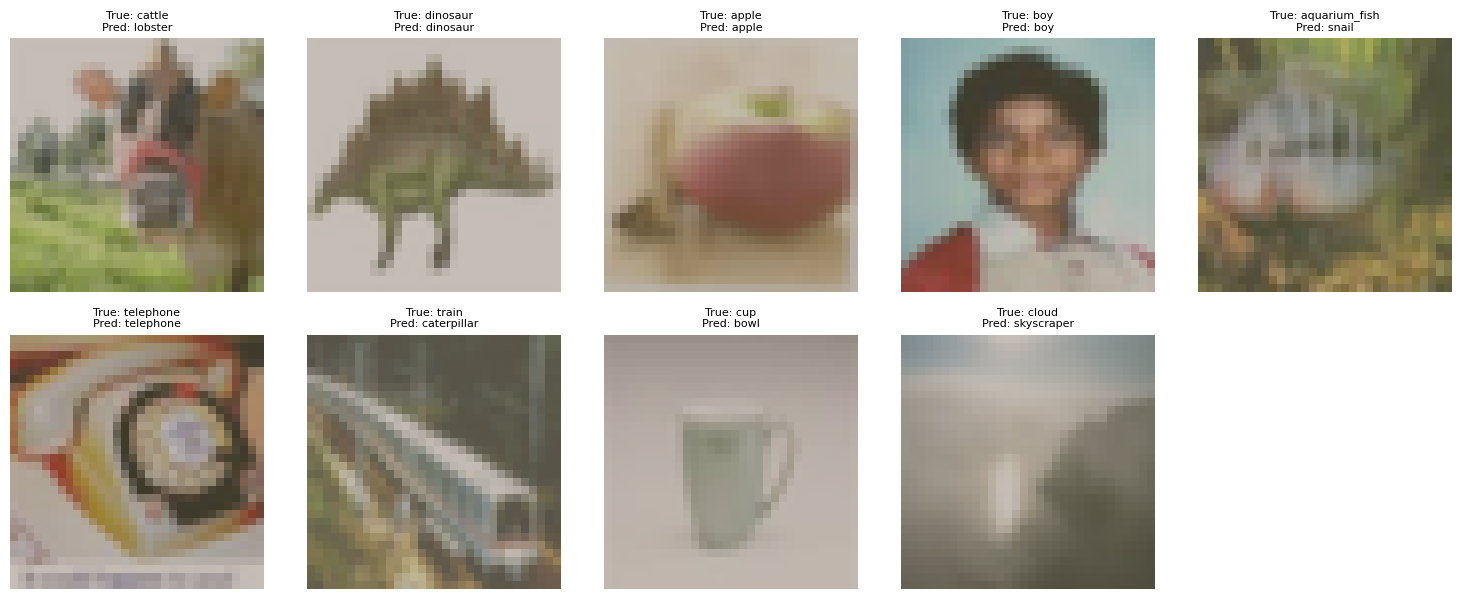

Epoch [13/64], Step [100/781], Loss: 1.883, Acc: 48.16%
Epoch [13/64], Step [200/781], Loss: 1.782, Acc: 49.15%
Epoch [13/64], Step [300/781], Loss: 1.804, Acc: 49.39%
Epoch [13/64], Step [400/781], Loss: 1.834, Acc: 49.39%
Epoch [13/64], Step [500/781], Loss: 1.822, Acc: 49.48%
Epoch [13/64], Step [600/781], Loss: 1.823, Acc: 49.66%
Epoch [13/64], Step [700/781], Loss: 1.799, Acc: 49.90%


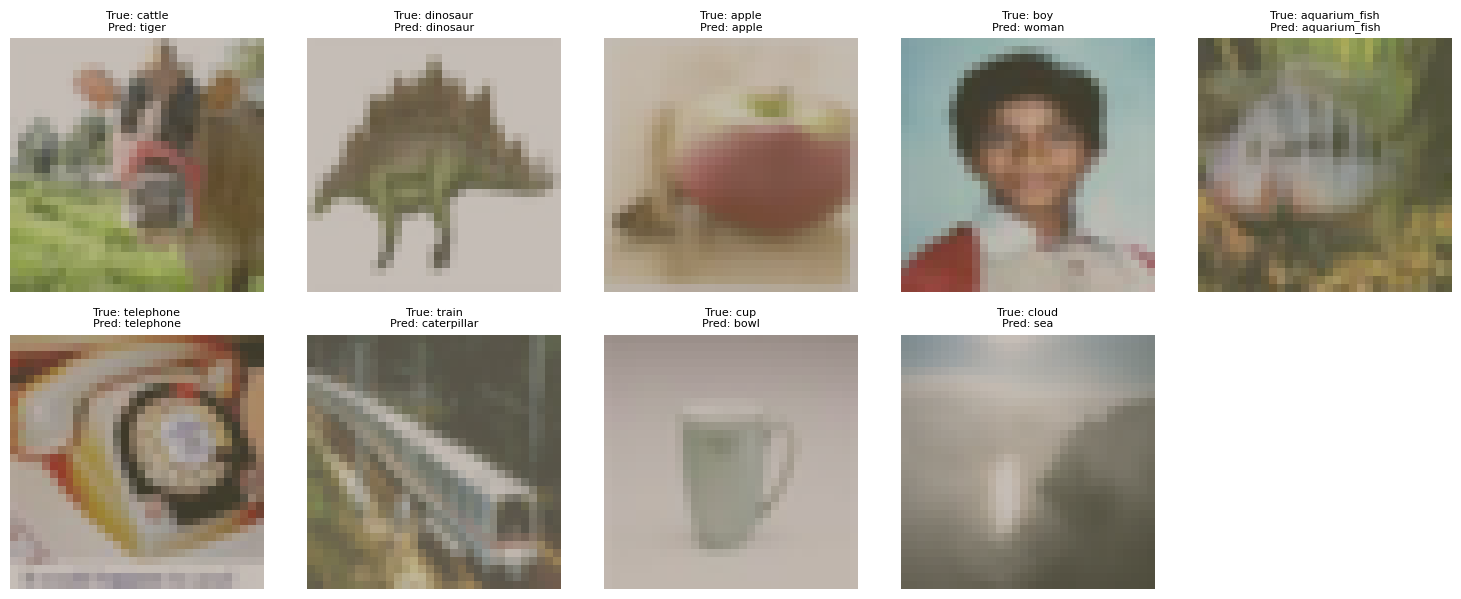

Epoch [14/64], Step [100/781], Loss: 1.814, Acc: 50.08%
Epoch [14/64], Step [200/781], Loss: 1.761, Acc: 50.69%
Epoch [14/64], Step [300/781], Loss: 1.756, Acc: 50.84%
Epoch [14/64], Step [400/781], Loss: 1.807, Acc: 50.80%
Epoch [14/64], Step [500/781], Loss: 1.751, Acc: 51.09%
Epoch [14/64], Step [600/781], Loss: 1.766, Acc: 51.12%
Epoch [14/64], Step [700/781], Loss: 1.786, Acc: 51.14%


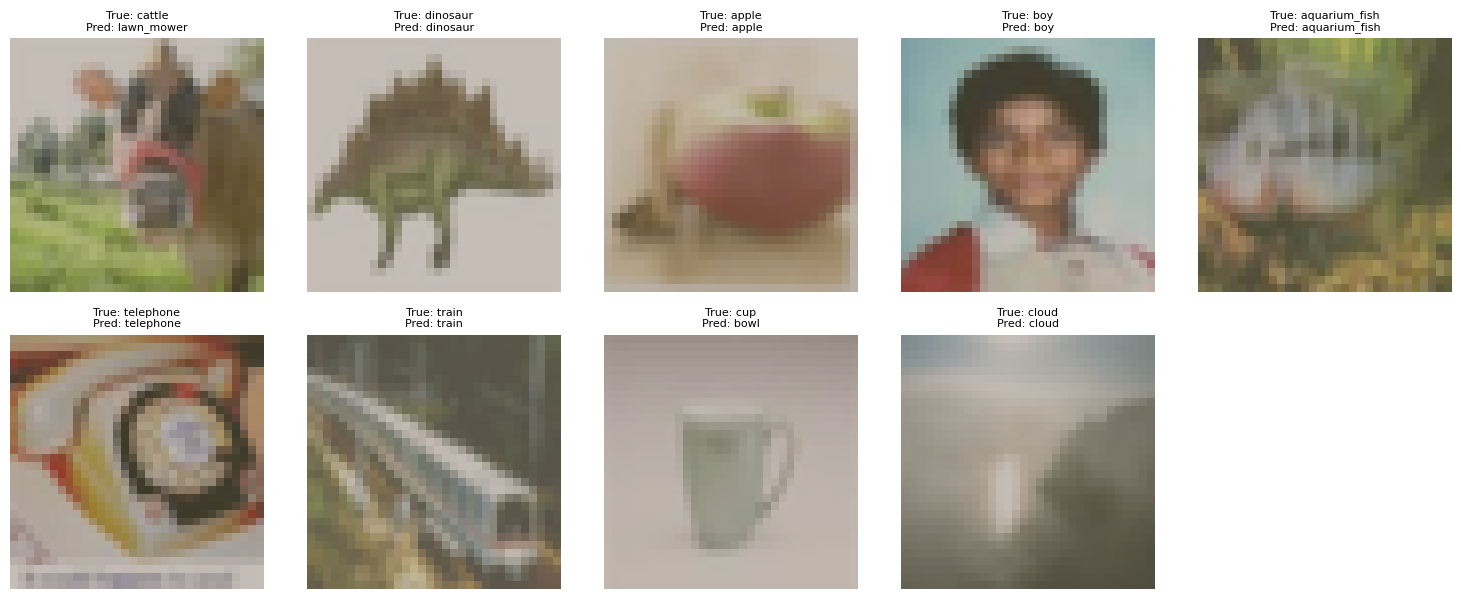

Epoch [15/64], Step [100/781], Loss: 1.752, Acc: 51.41%
Epoch [15/64], Step [200/781], Loss: 1.717, Acc: 51.84%
Epoch [15/64], Step [300/781], Loss: 1.738, Acc: 51.94%
Epoch [15/64], Step [400/781], Loss: 1.749, Acc: 51.88%
Epoch [15/64], Step [500/781], Loss: 1.722, Acc: 52.00%
Epoch [15/64], Step [600/781], Loss: 1.791, Acc: 51.90%
Epoch [15/64], Step [700/781], Loss: 1.738, Acc: 51.91%


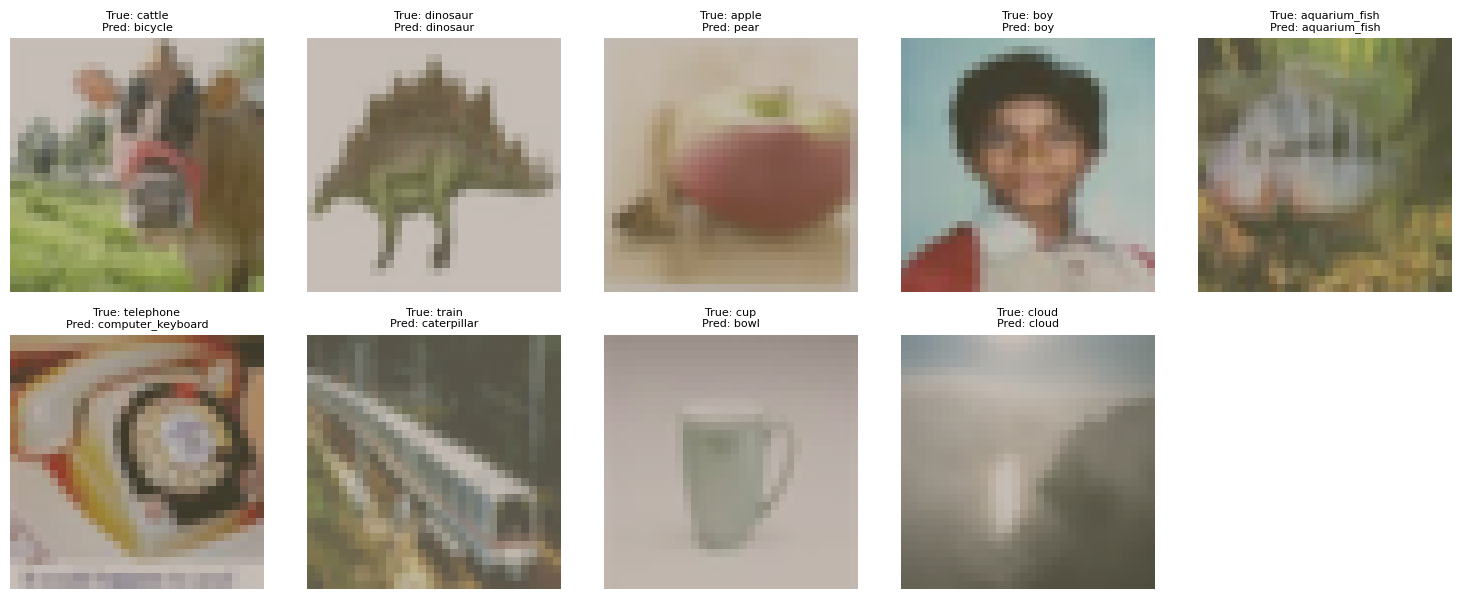

Epoch [16/64], Step [100/781], Loss: 1.743, Acc: 52.22%
Epoch [16/64], Step [200/781], Loss: 1.674, Acc: 52.86%
Epoch [16/64], Step [300/781], Loss: 1.696, Acc: 52.91%
Epoch [16/64], Step [400/781], Loss: 1.726, Acc: 52.77%
Epoch [16/64], Step [500/781], Loss: 1.682, Acc: 52.82%
Epoch [16/64], Step [600/781], Loss: 1.728, Acc: 52.77%
Epoch [16/64], Step [700/781], Loss: 1.718, Acc: 52.81%


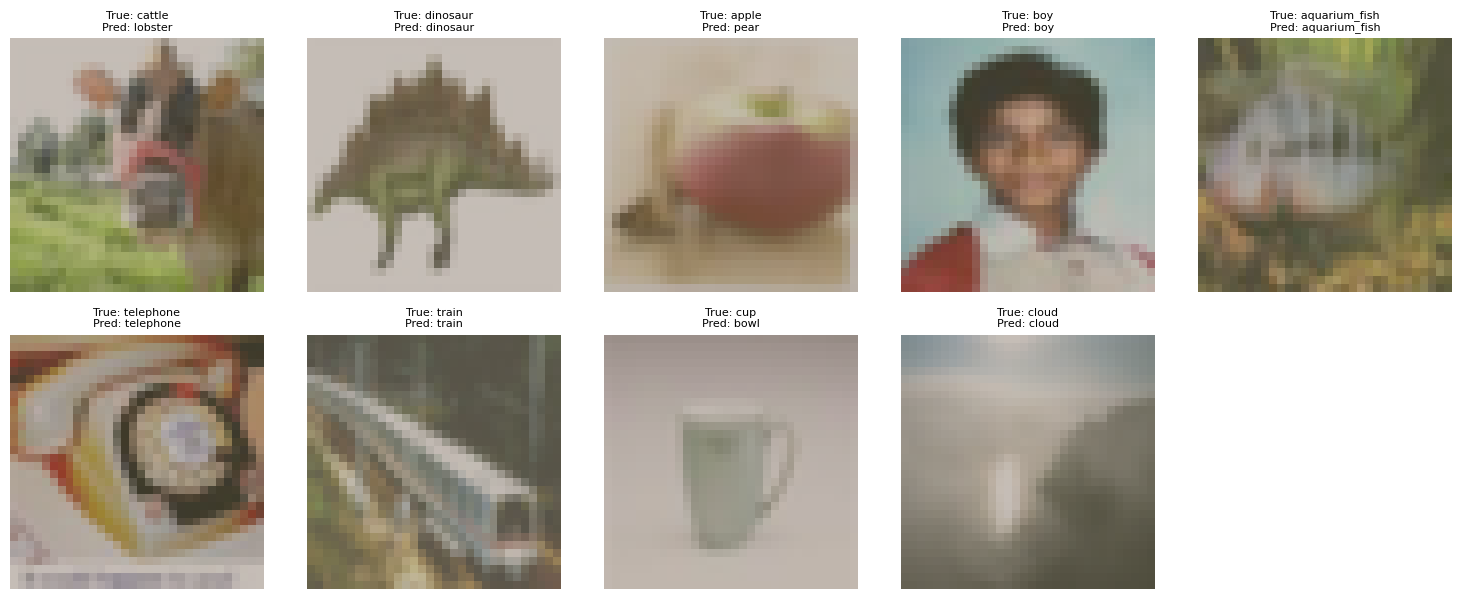

Epoch [17/64], Step [100/781], Loss: 1.734, Acc: 51.95%
Epoch [17/64], Step [200/781], Loss: 1.607, Acc: 53.54%
Epoch [17/64], Step [300/781], Loss: 1.690, Acc: 53.49%
Epoch [17/64], Step [400/781], Loss: 1.670, Acc: 53.69%
Epoch [17/64], Step [500/781], Loss: 1.640, Acc: 53.86%
Epoch [17/64], Step [600/781], Loss: 1.687, Acc: 53.82%
Epoch [17/64], Step [700/781], Loss: 1.666, Acc: 53.82%


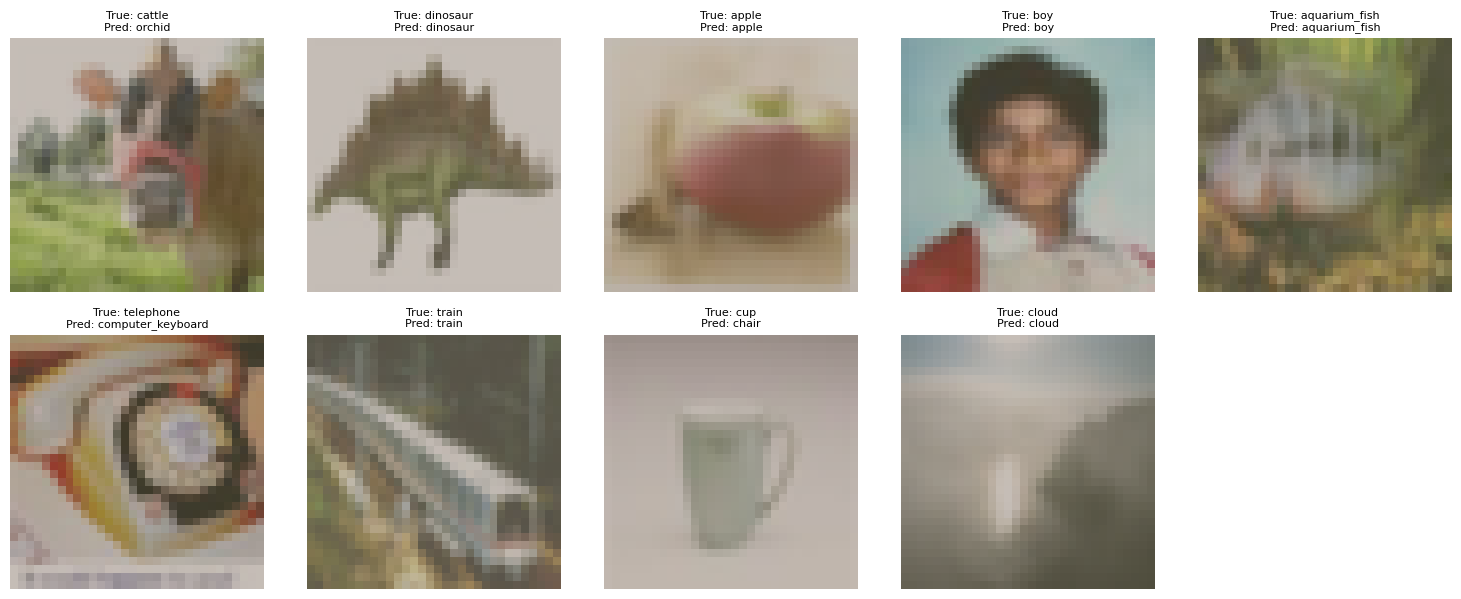

Epoch [18/64], Step [100/781], Loss: 1.677, Acc: 53.88%
Epoch [18/64], Step [200/781], Loss: 1.614, Acc: 54.21%
Epoch [18/64], Step [300/781], Loss: 1.650, Acc: 54.35%
Epoch [18/64], Step [400/781], Loss: 1.650, Acc: 54.55%
Epoch [18/64], Step [500/781], Loss: 1.631, Acc: 54.61%
Epoch [18/64], Step [600/781], Loss: 1.658, Acc: 54.51%
Epoch [18/64], Step [700/781], Loss: 1.645, Acc: 54.50%


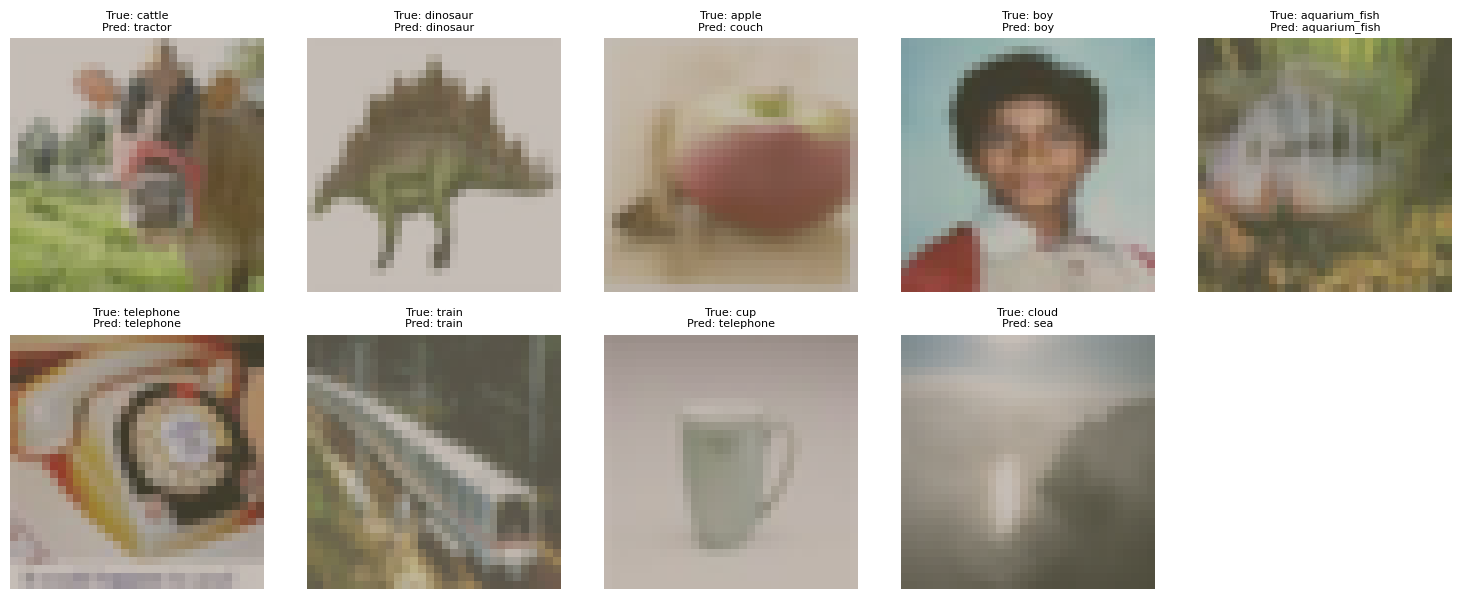

Epoch [19/64], Step [100/781], Loss: 1.674, Acc: 53.25%
Epoch [19/64], Step [200/781], Loss: 1.549, Acc: 55.14%
Epoch [19/64], Step [300/781], Loss: 1.632, Acc: 54.90%
Epoch [19/64], Step [400/781], Loss: 1.651, Acc: 54.75%
Epoch [19/64], Step [500/781], Loss: 1.621, Acc: 54.72%
Epoch [19/64], Step [600/781], Loss: 1.641, Acc: 54.69%
Epoch [19/64], Step [700/781], Loss: 1.593, Acc: 54.85%


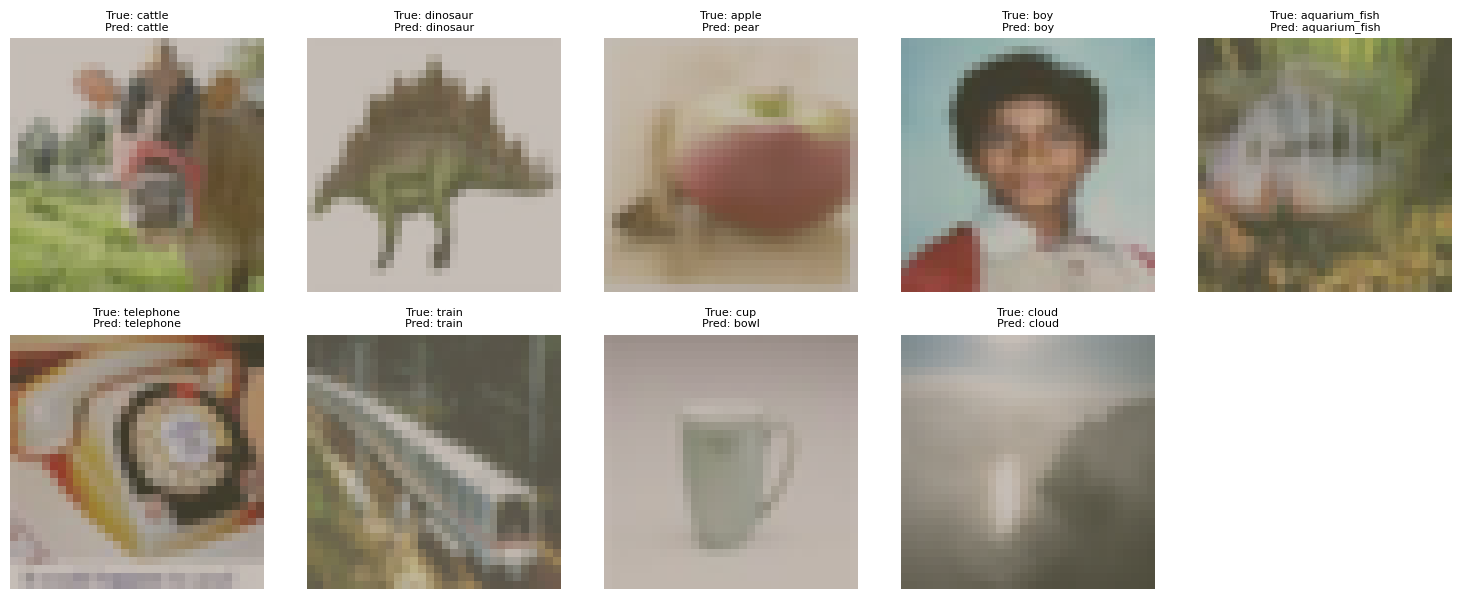

Epoch [20/64], Step [100/781], Loss: 1.643, Acc: 54.19%
Epoch [20/64], Step [200/781], Loss: 1.550, Acc: 55.41%
Epoch [20/64], Step [300/781], Loss: 1.584, Acc: 55.46%
Epoch [20/64], Step [400/781], Loss: 1.598, Acc: 55.48%
Epoch [20/64], Step [500/781], Loss: 1.566, Acc: 55.77%
Epoch [20/64], Step [600/781], Loss: 1.610, Acc: 55.79%
Epoch [20/64], Step [700/781], Loss: 1.580, Acc: 55.94%


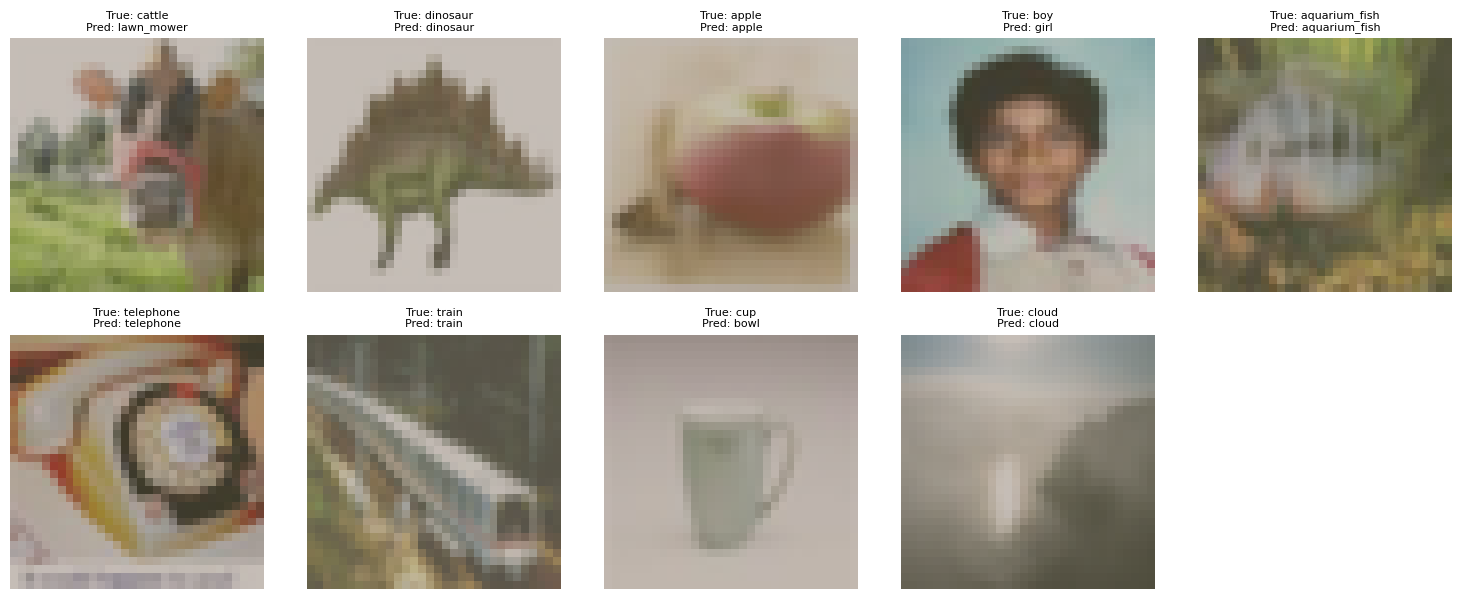

Epoch [21/64], Step [100/781], Loss: 1.590, Acc: 55.47%
Epoch [21/64], Step [200/781], Loss: 1.493, Acc: 56.42%
Epoch [21/64], Step [300/781], Loss: 1.546, Acc: 56.46%
Epoch [21/64], Step [400/781], Loss: 1.574, Acc: 56.31%
Epoch [21/64], Step [500/781], Loss: 1.523, Acc: 56.51%
Epoch [21/64], Step [600/781], Loss: 1.596, Acc: 56.46%
Epoch [21/64], Step [700/781], Loss: 1.518, Acc: 56.66%


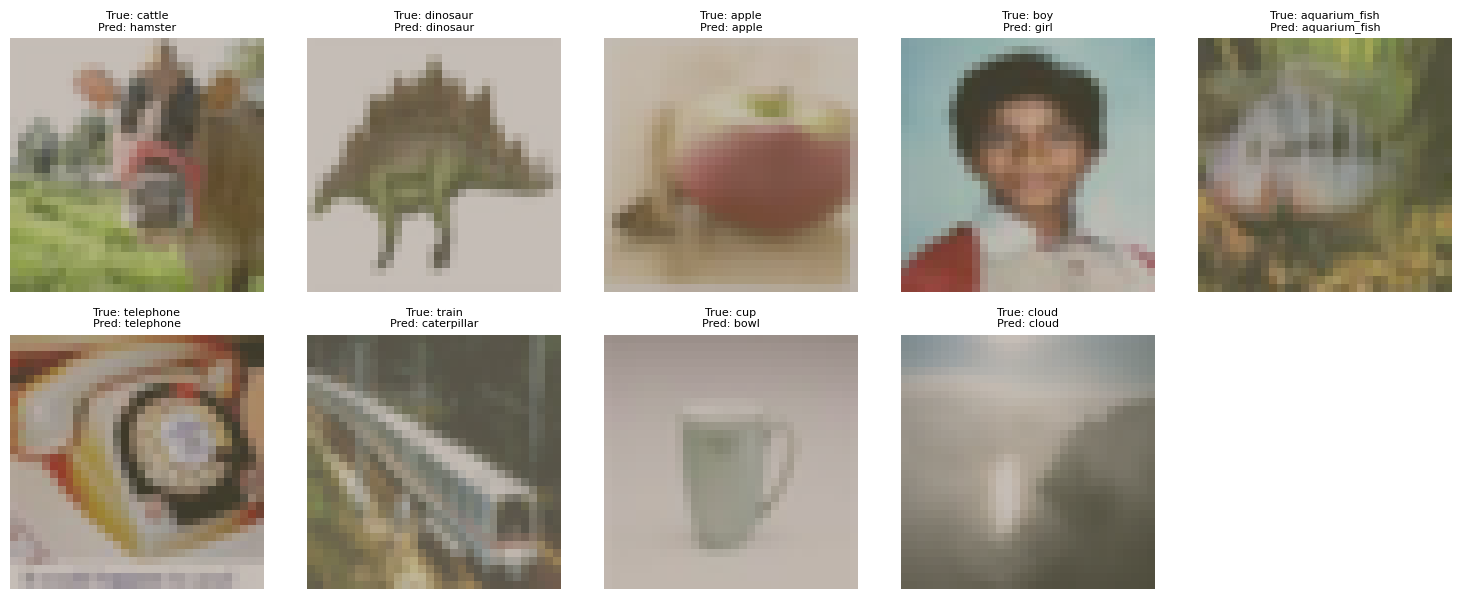

Epoch [22/64], Step [100/781], Loss: 1.547, Acc: 56.48%
Epoch [22/64], Step [200/781], Loss: 1.482, Acc: 57.23%
Epoch [22/64], Step [300/781], Loss: 1.511, Acc: 57.27%
Epoch [22/64], Step [400/781], Loss: 1.535, Acc: 57.19%
Epoch [22/64], Step [500/781], Loss: 1.505, Acc: 57.26%
Epoch [22/64], Step [600/781], Loss: 1.532, Acc: 57.18%
Epoch [22/64], Step [700/781], Loss: 1.500, Acc: 57.27%


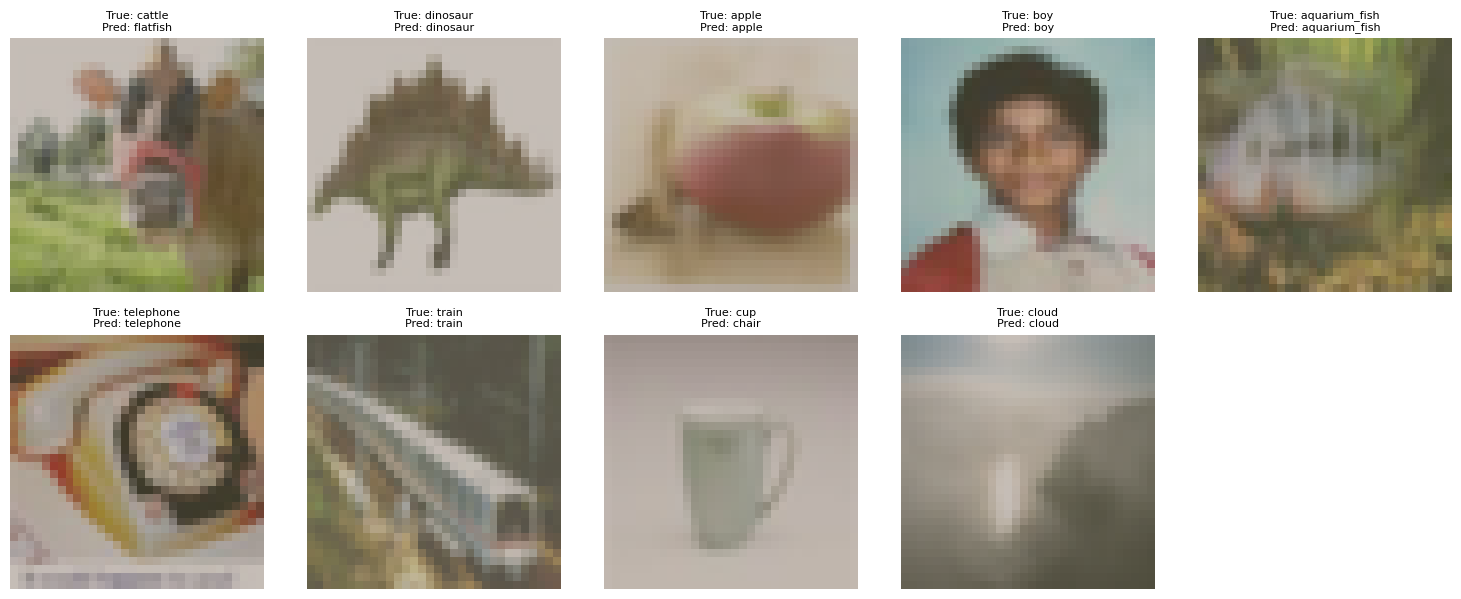

Epoch [23/64], Step [100/781], Loss: 1.515, Acc: 57.58%
Epoch [23/64], Step [200/781], Loss: 1.431, Acc: 58.54%
Epoch [23/64], Step [300/781], Loss: 1.474, Acc: 58.66%
Epoch [23/64], Step [400/781], Loss: 1.484, Acc: 58.48%
Epoch [23/64], Step [500/781], Loss: 1.476, Acc: 58.37%
Epoch [23/64], Step [600/781], Loss: 1.502, Acc: 58.31%
Epoch [23/64], Step [700/781], Loss: 1.459, Acc: 58.40%


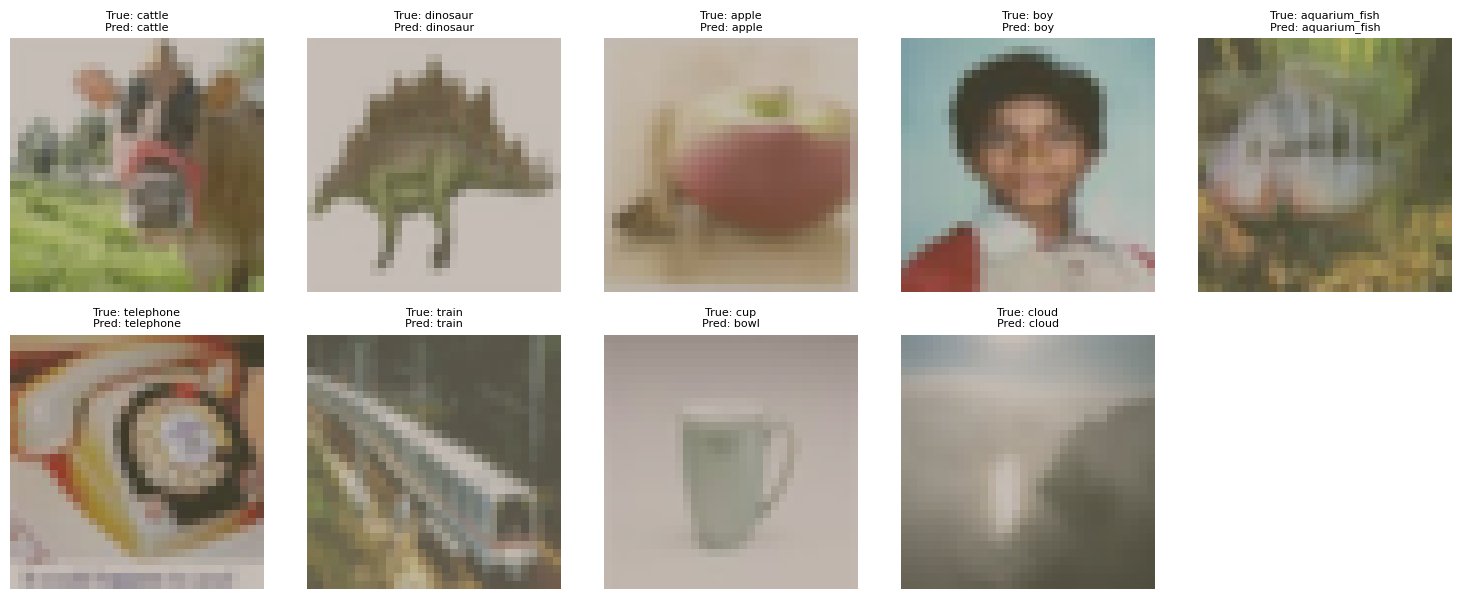

Epoch [24/64], Step [100/781], Loss: 1.512, Acc: 57.55%
Epoch [24/64], Step [200/781], Loss: 1.403, Acc: 58.73%
Epoch [24/64], Step [300/781], Loss: 1.451, Acc: 58.81%
Epoch [24/64], Step [400/781], Loss: 1.435, Acc: 58.93%
Epoch [24/64], Step [500/781], Loss: 1.445, Acc: 58.89%
Epoch [24/64], Step [600/781], Loss: 1.461, Acc: 58.83%
Epoch [24/64], Step [700/781], Loss: 1.446, Acc: 58.83%


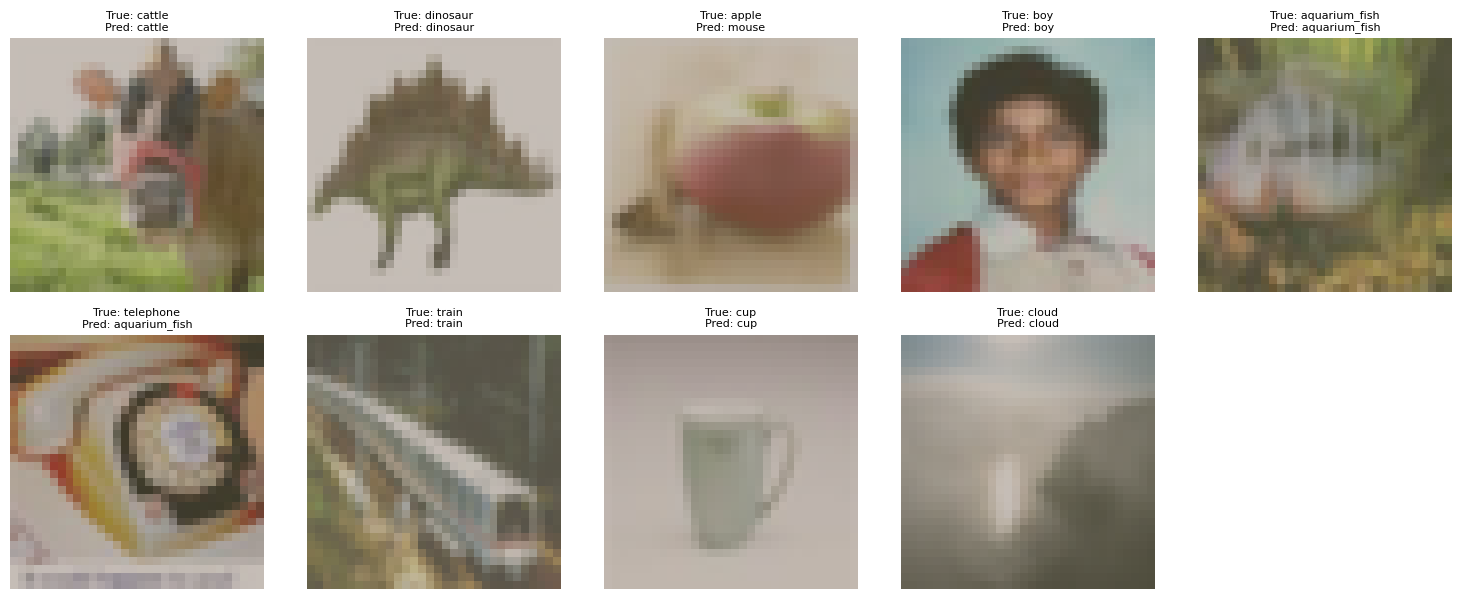

Epoch [25/64], Step [100/781], Loss: 1.445, Acc: 59.05%
Epoch [25/64], Step [200/781], Loss: 1.385, Acc: 59.60%
Epoch [25/64], Step [300/781], Loss: 1.419, Acc: 59.76%
Epoch [25/64], Step [400/781], Loss: 1.405, Acc: 59.84%
Epoch [25/64], Step [500/781], Loss: 1.408, Acc: 59.87%
Epoch [25/64], Step [600/781], Loss: 1.431, Acc: 59.76%
Epoch [25/64], Step [700/781], Loss: 1.408, Acc: 59.82%


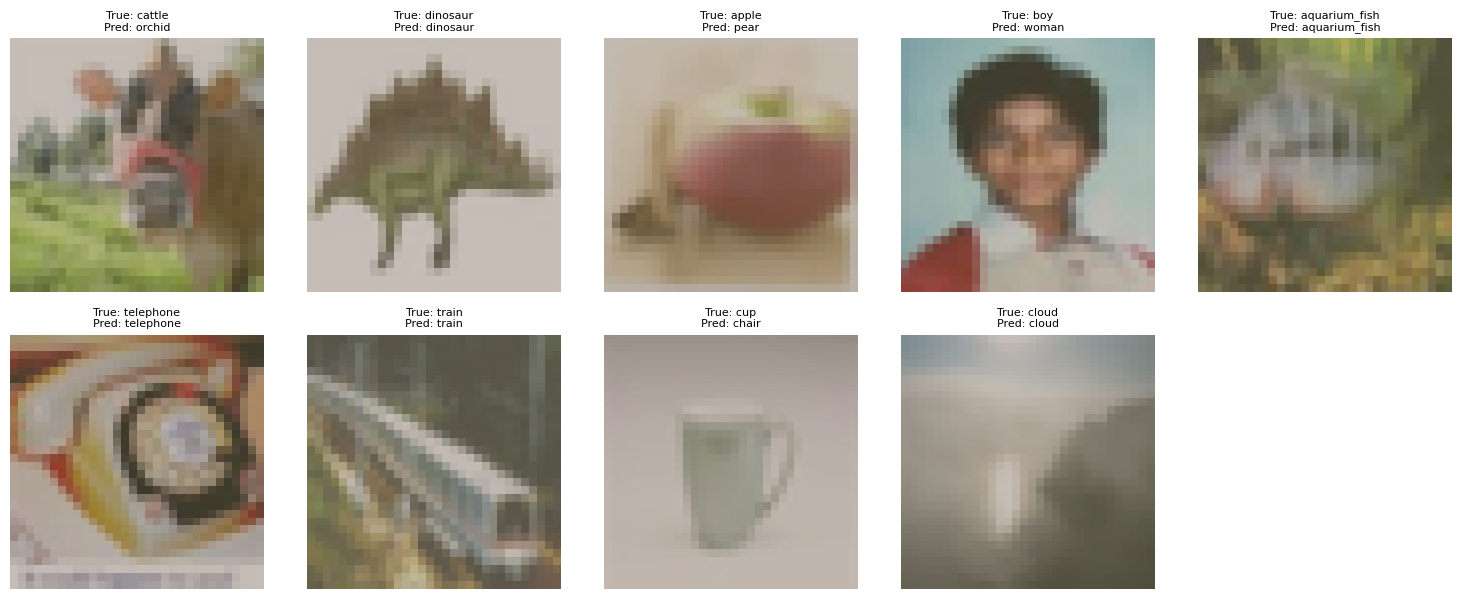

Epoch [26/64], Step [100/781], Loss: 1.411, Acc: 59.22%
Epoch [26/64], Step [200/781], Loss: 1.335, Acc: 60.43%
Epoch [26/64], Step [300/781], Loss: 1.343, Acc: 60.90%
Epoch [26/64], Step [400/781], Loss: 1.369, Acc: 60.86%
Epoch [26/64], Step [500/781], Loss: 1.369, Acc: 61.05%
Epoch [26/64], Step [600/781], Loss: 1.373, Acc: 61.05%
Epoch [26/64], Step [700/781], Loss: 1.350, Acc: 61.11%


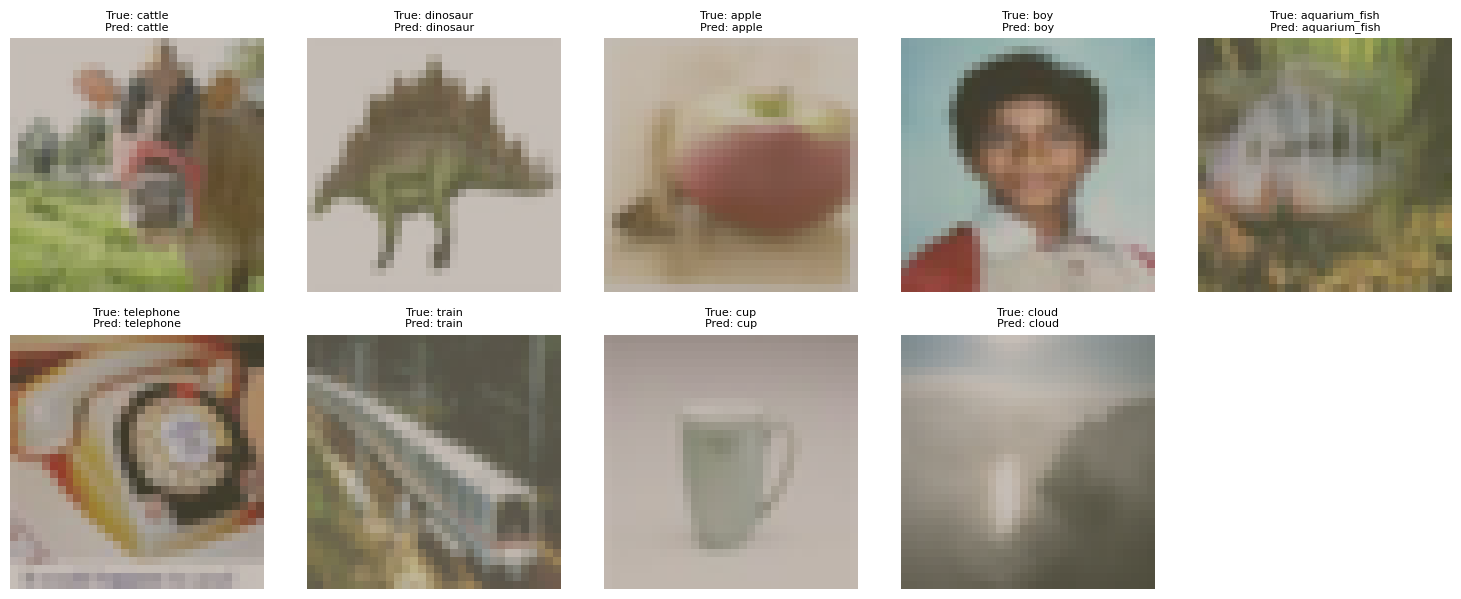

Epoch [27/64], Step [100/781], Loss: 1.342, Acc: 61.45%
Epoch [27/64], Step [200/781], Loss: 1.324, Acc: 61.70%
Epoch [27/64], Step [300/781], Loss: 1.307, Acc: 61.79%
Epoch [27/64], Step [400/781], Loss: 1.321, Acc: 61.96%
Epoch [27/64], Step [500/781], Loss: 1.326, Acc: 61.89%
Epoch [27/64], Step [600/781], Loss: 1.357, Acc: 61.82%
Epoch [27/64], Step [700/781], Loss: 1.318, Acc: 61.94%


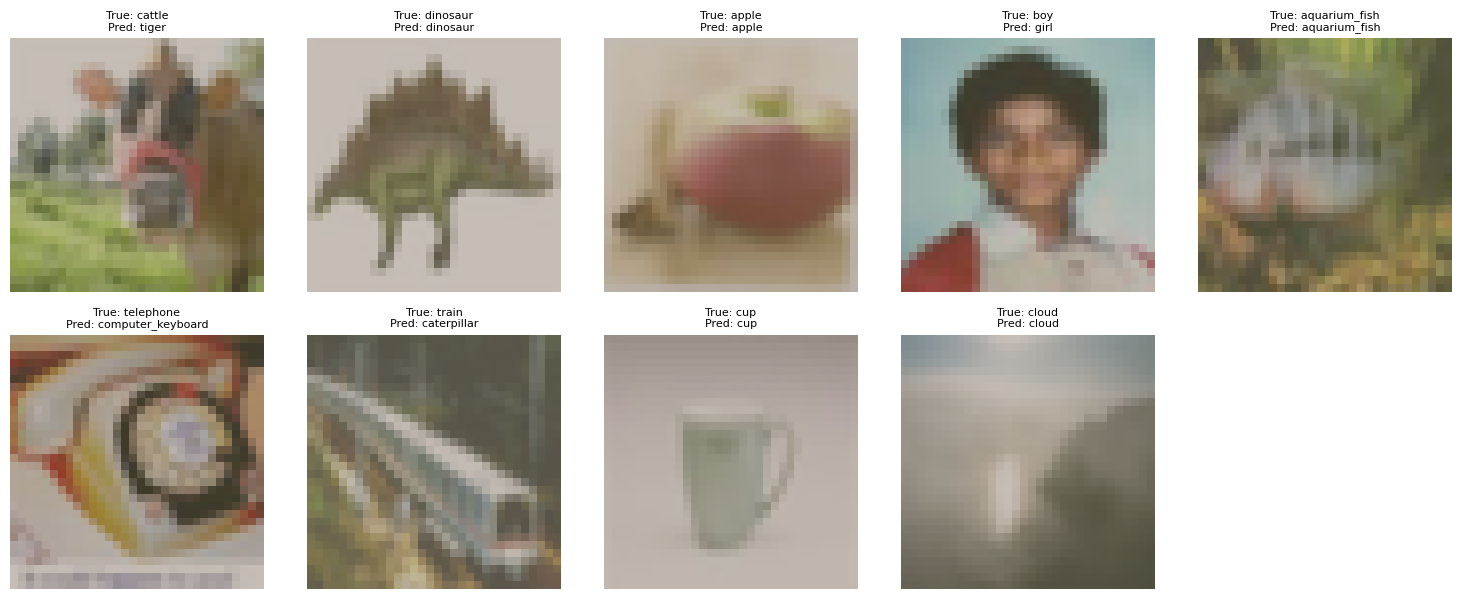

Epoch [28/64], Step [100/781], Loss: 1.319, Acc: 61.52%


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(R.parameters(), lr=0.2, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_of_epochs)

R = R.to(device)

for epoch in range(num_of_epochs):
    R.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = R(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_of_epochs}], Step [{i+1}/{len(train_loader)}], '
                    f'Loss: {running_loss/100:.3f}, '
                    f'Acc: {100.*correct/total:.2f}%')
            running_loss = 0.0
    
    scheduler.step()

    # Display images and predictions at the end of each epoch
    if (epoch + 1) % 1 == 0:  # Change this number to control visualization frequency
        R.eval()
        with torch.no_grad():
            images, labels = next(iter(train_loader))
            images, labels = images[:9].to(device), labels[:9].to(device)
            outputs = R(images)
            _, predictions = outputs.max(1)
            show_images(images, labels.cpu(), predictions.cpu(), class_names)
        R.train()